In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

C:\Users\rajan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE =256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 2 1 1 0 1 0 0 1 0 1 2 1 1 0 1]


In [8]:
# see the first image in 3d array
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[133. 119. 119.]
  [134. 120. 120.]
  [143. 129. 129.]
  ...
  [140. 126. 125.]
  [138. 124. 123.]
  [141. 127. 126.]]

 [[129. 115. 115.]
  [129. 115. 115.]
  [137. 123. 123.]
  ...
  [144. 130. 129.]
  [145. 131. 130.]
  [149. 135. 134.]]

 [[131. 117. 117.]
  [128. 114. 114.]
  [134. 120. 120.]
  ...
  [153. 139. 138.]
  [161. 147. 146.]
  [169. 155. 154.]]

 ...

 [[182. 173. 178.]
  [183. 174. 179.]
  [182. 173. 178.]
  ...
  [194. 186. 184.]
  [191. 183. 181.]
  [190. 182. 180.]]

 [[180. 171. 176.]
  [182. 173. 178.]
  [182. 173. 178.]
  ...
  [190. 182. 180.]
  [187. 179. 177.]
  [190. 182. 180.]]

 [[183. 174. 179.]
  [184. 175. 180.]
  [184. 175. 180.]
  ...
  [180. 172. 170.]
  [183. 175. 173.]
  [192. 184. 182.]]]


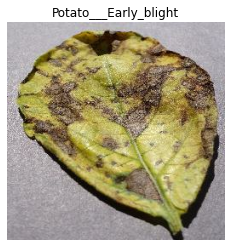

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

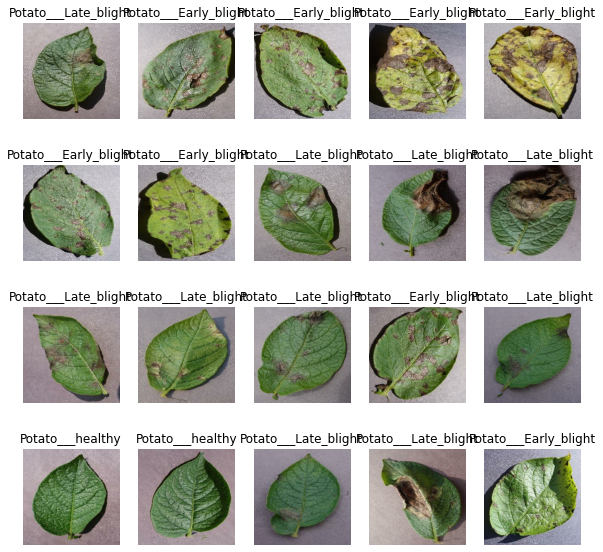

In [10]:
# suppose we will se 18 images
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

68

In [12]:
# 80% ==>training
# 20% ==> 10% validation, 10% test

In [13]:
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partition_tf(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=1000):
    
    ds_size =len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
from tensorflow.keras import layers

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\rajan\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 547ms/step - accuracy: 0.4927 - loss: 0.9310 - val_accuracy: 0.6406 - val_loss: 0.7933
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 568ms/step - accuracy: 0.7251 - loss: 0.6367 - val_accuracy: 0.8229 - val_loss: 0.4003
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 560ms/step - accuracy: 0.8256 - loss: 0.4201 - val_accuracy: 0.8646 - val_loss: 0.3373
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 569ms/step - accuracy: 0.8774 - loss: 0.3234 - val_accuracy: 0.7865 - val_loss: 0.4156
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 557ms/step - accuracy: 0.8470 - loss: 0.3544 - val_accuracy: 0.8229 - val_loss: 0.4040
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step - accuracy: 0.8679 - loss: 0.3187 - val_accuracy: 0.9010 - val_loss: 0.2149
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - accuracy: 0.9099 - loss: 0.2076 - val_accuracy: 0.8750 - val_loss: 0.3581
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - accuracy: 0.9138 - loss: 0.2038 - val_accu

In [32]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.9895 - loss: 0.0269


In [33]:
scores

[0.027937743812799454, 0.98828125]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
len(history.history['accuracy'])

50

In [38]:
history.history['accuracy']

[0.5289351940155029,
 0.7384259104728699,
 0.8391203880310059,
 0.8611111044883728,
 0.8692129850387573,
 0.8859953880310059,
 0.9230324029922485,
 0.9207175970077515,
 0.9195601940155029,
 0.9542824029922485,
 0.9490740895271301,
 0.9513888955116272,
 0.9670138955116272,
 0.9606481194496155,
 0.9571759104728699,
 0.96875,
 0.9635416865348816,
 0.9670138955116272,
 0.9745370149612427,
 0.9623842835426331,
 0.9768518805503845,
 0.9710648059844971,
 0.96875,
 0.9849537014961243,
 0.9618055820465088,
 0.9722222089767456,
 0.9733796119689941,
 0.9762731194496155,
 0.984375,
 0.9872685074806213,
 0.9901620149612427,
 0.9762731194496155,
 0.9890046119689941,
 0.9785879850387573,
 0.9884259104728699,
 0.9866898059844971,
 0.9942129850387573,
 0.9924768805503845,
 0.9901620149612427,
 0.9918981194496155,
 0.9901620149612427,
 0.9768518805503845,
 0.9814814925193787,
 0.9913194179534912,
 0.9878472089767456,
 0.9913194179534912,
 0.9837962985038757,
 0.984375,
 0.9826388955116272,
 0.9907407164

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

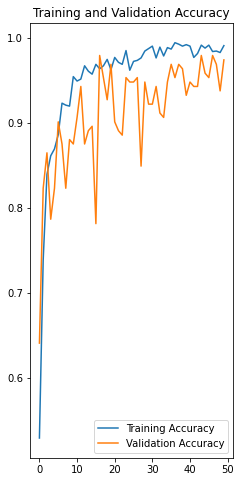

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

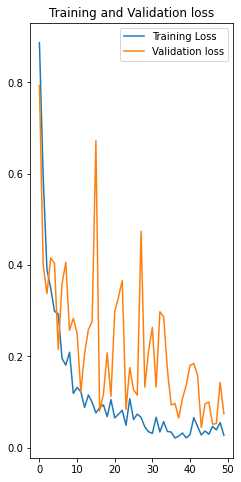

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [42]:
for images_batch, labels_batch in test_ds.take(1):
    
    print(images_batch[0])

tf.Tensor(
[[[189. 183. 187.]
  [192. 186. 190.]
  [196. 190. 194.]
  ...
  [147. 134. 141.]
  [153. 140. 147.]
  [149. 136. 143.]]

 [[194. 188. 192.]
  [196. 190. 194.]
  [199. 193. 197.]
  ...
  [148. 135. 142.]
  [150. 137. 144.]
  [146. 133. 140.]]

 [[194. 188. 192.]
  [196. 190. 194.]
  [199. 193. 197.]
  ...
  [145. 132. 139.]
  [144. 131. 138.]
  [144. 131. 138.]]

 ...

 [[208. 200. 198.]
  [209. 201. 199.]
  [209. 201. 199.]
  ...
  [147. 133. 133.]
  [156. 142. 142.]
  [153. 139. 139.]]

 [[205. 197. 195.]
  [207. 199. 197.]
  [207. 199. 197.]
  ...
  [145. 131. 131.]
  [155. 141. 141.]
  [152. 138. 138.]]

 [[202. 194. 192.]
  [204. 196. 194.]
  [204. 196. 194.]
  ...
  [136. 122. 122.]
  [146. 132. 132.]
  [148. 134. 134.]]], shape=(256, 256, 3), dtype=float32)


first image to predict
first image's actual label: Potato___healthy


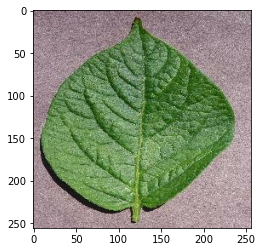

In [43]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

In [44]:
import numpy as np
np.argmax([1.8158805e-04, 9.9981838e-01, 2.7451842e-13])

1

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
predicted label: Potato___healthy


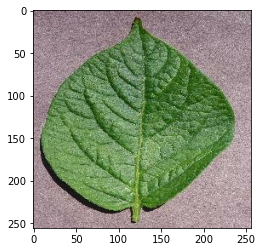

In [45]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array =tf.expand_dims(img_array,0)# create a batch
    
    prediction = model.predict(img_array)
    
    predicted_class =class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.argmax(prediction[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


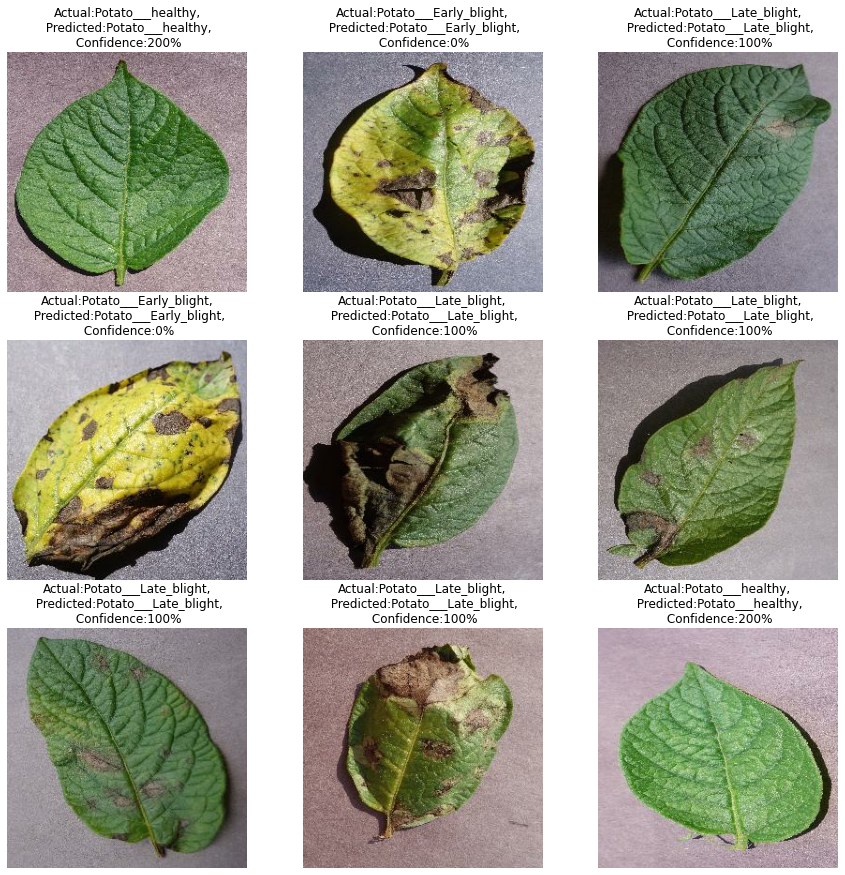

In [47]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax =plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis("off")
        

In [51]:
# model_version=1
# model.save(f"../models/{model_version}")

In [52]:
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'